In [1]:
# Priority-weighted Load Restoration Problem for Improved Resilience in Distribution Systems
# MPC 

In [2]:
# Install/add relevant Julia packages

using Pkg
Pkg.add("JuMP")
Pkg.add("Ipopt")
Pkg.add("GLPK")
Pkg.add("Cbc")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("OpenDSSDirect")
Pkg.add("Plots")

#Pkg.add("SCIP")
#Pkg.add("Alpine")
#Pkg.add("PyPlot") 
#Pkg.add("GR")
#Pkg.add("UnicodePlots")


In [3]:
# Import/load relevant Julia packages

using JuMP
using Ipopt
using GLPK
using Cbc
using CSV
using DataFrames
using OpenDSSDirect
using Plots

#using SCIP
#using Alpine
#using OSQP
#using TimeSeries
#using ParameterJuMP
#using Statistics


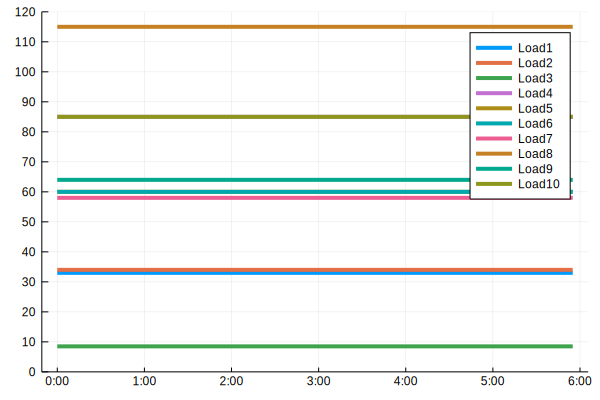

In [4]:
# Load demand

load_new = [33, 34, 8.5, 85, 60, 60, 58, 115, 64, 85]
importance_factor = [1.0, 1.0, 0.9, 0.85, 0.8, 0.65, 0.45, 0.4, 0.3, 0.3]
num_time_steps = 72

load1 = zeros(1,num_time_steps)
load2 = zeros(1,num_time_steps)
load3 = zeros(1,num_time_steps)
load4 = zeros(1,num_time_steps)
load5 = zeros(1,num_time_steps)
load6 = zeros(1,num_time_steps)
load7 = zeros(1,num_time_steps)
load8 = zeros(1,num_time_steps)
load9 = zeros(1,num_time_steps)
load10 = zeros(1,num_time_steps)

for l in 1:num_time_steps
    load1[l] = load_new[1]
    load2[l] = load_new[2]
    load3[l] = load_new[3]
    load4[l] = load_new[4]
    load5[l] = load_new[5]
    load6[l] = load_new[6]
    load7[l] = load_new[7]
    load8[l] = load_new[8]
    load9[l] = load_new[9]
    load10[l] = load_new[10]
end

gr()
tx = 1:num_time_steps
plot(tx,load1',label="Load1", lw = 4)
plot!(tx,load2',label="Load2", lw = 4)
plot!(tx,load3',label="Load3", lw = 4)
plot!(tx,load4',label="Load4", lw = 4)
plot!(tx,load5',label="Load5", lw = 4)
plot!(tx,load6',label="Load6", lw = 4)
plot!(tx,load7',label="Load7", lw = 4)
plot!(tx,load8',label="Load8", lw = 4)
plot!(tx,load9',label="Load9", lw = 4)
plot!(tx,load10',label="Load10", lw = 4, xticks = (1:12:84, "$tt:00" for tt in 0:6), ylims=(0,120),yticks = 0:10:120)


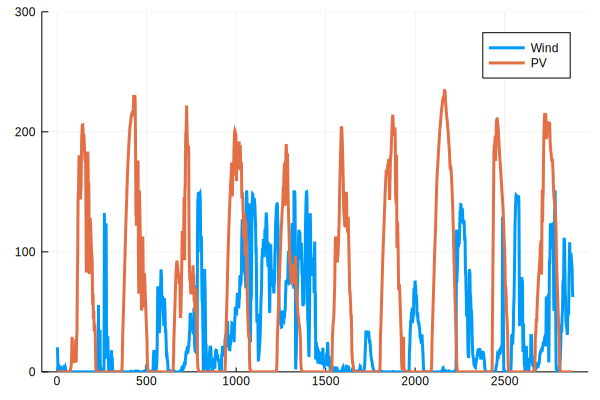

In [5]:
# Load exogenous data - load profile & renewable energy generation profile
    # Normalized (between 0 and 1) time series data with 5 minutes resolution

exo_data_path = "/Users/aeseye/Desktop/AGM-Resilience-Project/agm_resilience/agm_resiliency/dss_gym_env/dss_envs/envs/data/13BusCustomed/five_min_load_profile.csv"
exo_data = CSV.read(exo_data_path);

# Print the first six rows of the data
first(exo_data, 6)
# Data size
#println(size(exo_data))

Pwind = exo_data[:, 3]
Ppvv = exo_data[:, 4]
Pload = exo_data[:, 5:end];

WindMAX = 150
pvMAX = 300

txx = 1:length(Pwind)
plot(txx, WindMAX*Pwind, label="Wind", lw = 3)    #wind_max = 300
plot!(txx, pvMAX*Ppvv, label="PV", lw = 3, ylims=(0,300))      # pv_max = 200


In [6]:
# Pick 6 hours (i.e., 72 5-minutes) length exo data
    # for the 6h horizon (look-ahead) priority-weighted load pick-up optimization

DURATION = 71
#DURATION = 287
START_IDX = 1218
#START_IDX = 1
#NUM_OF_LOAD_BUS = 16
NUM_OF_LOAD_BUS = 10
FIVE_MIN_TO_HOUR = 5/60;
Δt = FIVE_MIN_TO_HOUR
#Δt = 1
load_profile = [load1; load2; load3; load4; load5; load6; load7; load8; load9; load10]
renewable_profile = exo_data[START_IDX:START_IDX+DURATION, 3:4]
wind_profile = renewable_profile[:, 1]
pv_profile = renewable_profile[:, 2]

load_profile = DataFrame(load_profile)
Actual_Load_Real = load_profile


,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0
2,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
3,8.5,8.5,8.5,8.5,8.5,8.5,8.5,8.5,8.5
4,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0
5,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
6,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
7,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0
8,115.0,115.0,115.0,115.0,115.0,115.0,115.0,115.0,115.0
9,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0


In [7]:
# Define the rated capacities (kW) of the renewable generators

wind_max = 150
pv_max = 300;


In [8]:
# Obtain the actual power (kW) time series of the renewable generations
 
Actual_wind = wind_max .* wind_profile
Actual_pv = pv_max .* pv_profile;


In [9]:
# Hourly Wind Power

Actual_wind_h = []
for hx in 1:12:size(Actual_wind, 1)-11
    push!(Actual_wind_h, (sum(Actual_wind[hx:hx+11])/12))   
end

# Hourly Solar Power

Actual_pv_h = []
for kx in 1:12:size(Actual_pv, 1)-11
    push!(Actual_pv_h, (sum(Actual_pv[kx:kx+11])/12))   
end


In [10]:
# Actual load demand (real power) at each time step

Actual_Load_Real_t = zeros(1, size(Actual_Load_Real,2))
for kdx in 1:size(Actual_Load_Real,2)
    Actual_Load_Real_t[kdx] = sum(Actual_Load_Real[:,kdx]) 
end

# Actual load demand at each node -- Does this make sense?

Actual_Load_Real_n = zeros(1, size(Actual_Load_Real,1))
for mdx in 1:size(Actual_Load_Real,1)
    Actual_Load_Real_n[mdx] = sum(Actual_Load_Real[mdx,:]) 
end

# Actual energy demand at each node -- in kWh  (Total energy at a node makes sense for time series loads)

Energy_n = zeros(1, size(Actual_Load_Real,1))
for mdx in 1:size(Actual_Load_Real,1)
    Energy_n[mdx] = sum(Actual_Load_Real[mdx,:])*Δt
end


In [11]:
# Define constant parameters

num_nodes = NUM_OF_LOAD_BUS
num_time_steps = size(Actual_Load_Real,2)
Δt = FIVE_MIN_TO_HOUR
Pl_act = Actual_Load_Real
Pwt = Actual_wind
Ppv = Actual_pv
load_priority_weight = [1.0, 1.0, 0.9, 0.85, 0.8, 0.65, 0.45, 0.4, 0.3, 0.3]
PmtMIN = 0
PmtMAX = 300
PchMAX = 200
PdischMAX = 200
Emt = 1000 #kWh
SOCMIN = 0.20
SOCMAX = 1.0 
SOC0 = 0.90
eff_ch = 0.95
eff_disch = 0.90
Ces = 800; #kWh
alpha =  0.02 #$/kWh -- penalty for wind power curtailment 
beta = 0.02; #$/kWh -- penalty for PV power curtailment


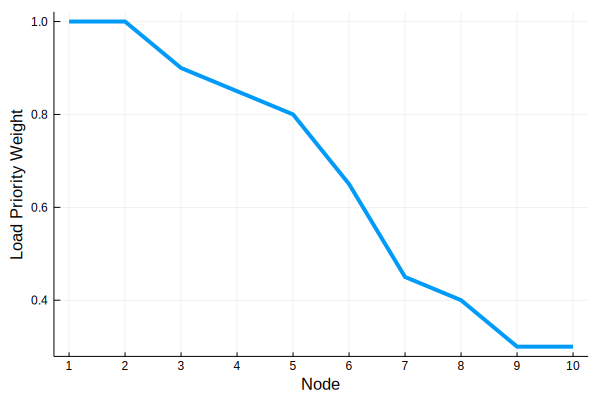

In [12]:
# Plot the Load Priority Weight

ty = 1:size(load_priority_weight,1)
plot(ty, load_priority_weight,lw = 4, label=false, xticks = (1:1:10, "$tt" for tt in 1:10),ylim=(0:0.05:1))
xlabel!("Node")
ylabel!("Load Priority Weight")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimization results/Load Priority.pdf")

In [13]:
# run_mpc() takes the previous battery SOC level and MT energy/fuel and current simulation step
# and returns optimized decisions for restored load, battery, MT and RE curtailment

function run_mpc(initial_SOC, initial_Emt, step)
    
    # Create an empty model
    
    model = Model()
    set_optimizer(model, GLPK.Optimizer)
    
    # Decision variables
    
    @variables model begin
        Pl[1:num_nodes]
        Pmt
        Pch
        Pdisch
        SOC
        Pwt_curt
        Ppv_curt
    end
    @variable(model, bch, Bin)
    @variable(model, bdisch, Bin)
    
    # Constraints

    # Power balance at time t1
    
    @constraint(model,(Pwt[step]-Pwt_curt) + (Ppv[step]-Ppv_curt) + Pmt - Pch + Pdisch == sum(Pl[1:num_nodes]))
    
    # Load Picked up
    
    @constraint(model, [i=1:num_nodes],Pl[i] >= 0)
    @constraint(model, [i=1:num_nodes],Pl[i] <= Pl_act[i,step])
    
    # Microturbine
    
    @constraint(model, Pmt >= PmtMIN)
    @constraint(model, Pmt <= PmtMAX)
    @constraint(model, (initial_Emt - Pmt*Δt) >= 0)
    
    # Energy storage 

    @constraint(model,Pch >= 0)
    @constraint(model, Pch <= bch * PchMAX)
    @constraint(model, Pdisch >= 0)
    @constraint(model, Pdisch <= bdisch * PdischMAX)
    @constraint(model, bch + bdisch == 1)
    @constraint(model, SOC >= SOCMIN)
    @constraint(model,SOC <= SOCMAX)              
    @constraint(model, SOC == initial_SOC + ((eff_ch*Pch/Ces) - (Pdisch/(eff_disch*Ces))) * Δt)

    # Curtailment -- renewable energy generation  

    @constraint(model,Pwt_curt >= 0)
    @constraint(model, Pwt_curt <= Pwt[step])
    @constraint(model, Ppv_curt >= 0)
    @constraint(model, Ppv_curt <= Ppv[step])
    
    # Objective function: maximize the total priority-weighted loads picked up
    
    @objective(model, Max,
               sum(load_priority_weight[1:num_nodes] .* Pl[1:num_nodes])
             - Δt*alpha*Pwt_curt
             - Δt*beta*Ppv_curt)

    optimize!(model)
    
    # Extract the model solution

    P_restored = JuMP.value.(Pl)
    Pmt_gen = JuMP.value.(Pmt)
    Pbat_charge = -1 .* JuMP.value.(Pch)
    Pbat_discharge = JuMP.value.(Pdisch)
    Pbat = Pbat_charge .+ Pbat_discharge
    SOCbat = JuMP.value.(SOC)
    Is_Charging = JuMP.value.(bch)
    Is_Discharging = JuMP.value.(bdisch)
    Pwt_cut = JuMP.value.(Pwt_curt)
    Ppv_cut = JuMP.value.(Ppv_curt)
    
    return P_restored, Pmt_gen, Pbat, SOCbat, Pwt_cut, Ppv_cut
end


run_mpc (generic function with 1 method)

In [14]:
# Call/run the MPC at each time step in rolling forward fashion
# until the last step of the optimization hiorizon

initial_SOC = 0.90
initial_Emt = 1000

P_restoredd = zeros(10,72)
Pmt_genn = zeros(1,72)
Pbatt = zeros(1,72)
SOCbatt = zeros(1,72)
Pwt_cutt = zeros(1,72)
Ppv_cutt = zeros(1,72)

for i in 1:72
    
    P_restored, Pmt_gen, Pbat, SOCbat, Pwt_cut, Ppv_cut = run_mpc(initial_SOC, initial_Emt, i)
    
    P_restoredd[:,i] = P_restored
    Pmt_genn[i] = Pmt_gen
    Pbatt[i] = Pbat
    SOCbatt[i] = SOCbat
    Pwt_cutt[i] = Pwt_cut
    Ppv_cutt[i] = Ppv_cut
    
    # Update the battery remaining SOC and microturbine remaing energy/fuel
    # and simulate one step forward in time
    
    initial_SOC = SOCbat
    initial_Emt = initial_Emt - Pmt_gen*Δt
    
end


In [15]:
# Restored load at each time step

P_restored_t = zeros(1, num_time_steps)
for jdx in 1:num_time_steps
    P_restored_t[jdx] = sum(P_restoredd[:,jdx]) 
end

# Restored load at each node

P_restored_n = zeros(1, num_nodes)
for ndx in 1:num_nodes
    P_restored_n[ndx] = sum(P_restoredd[ndx,:]) 
end

# Restored energy at each node

E_restored_n = zeros(1, num_nodes)
for qdx in 1:num_nodes
    E_restored_n[qdx] = (sum(P_restoredd[qdx,:]))*Δt
end


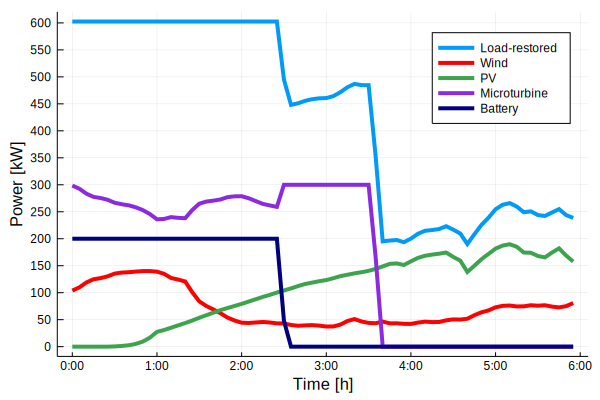

In [16]:
# Plot the results

gr();

t = 1:num_time_steps

plot(t, P_restored_t', label="Load-restored", lw = 4)
plot!(t, Pwt, label="Wind", lw = 4, c=:red)
plot!(t, Ppv, label="PV", lw =4)
plot!(t, Pmt_genn', label="Microturbine", lw = 4, c=:blueviolet)
plot!(t, Pbatt', label="Battery", lw = 4, 
    xticks = (1:12:84, "$tt:00" for tt in 0:6), yticks = -200:50:800, c=:navy, legend=:best)
xlabel!("Time [h]")
ylabel!("Power [kW]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/Dispatch.pdf")


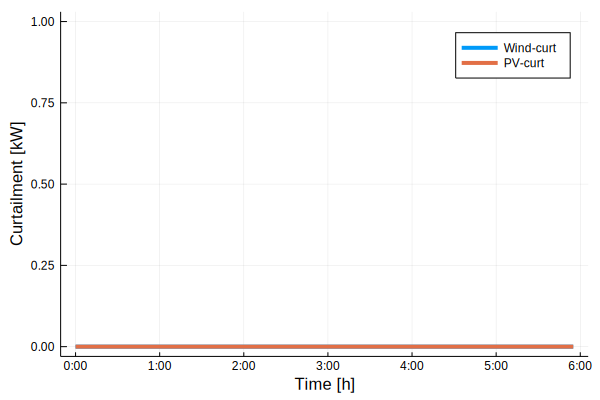

In [17]:
# Plot the renewable power curtailment

plot(t, Pwt_cutt', label="Wind-curt", lw = 4)#, linetype=:steppre)
plot!(t, Ppv_cutt', label="PV-curt", lw = 4, xticks = (1:12:84, "$tt:00" for tt in 0:6, ylim=(0,100)))#, linetype=:steppre)
xlabel!("Time [h]")
ylabel!("Curtailment [kW]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/Curtailment.pdf")


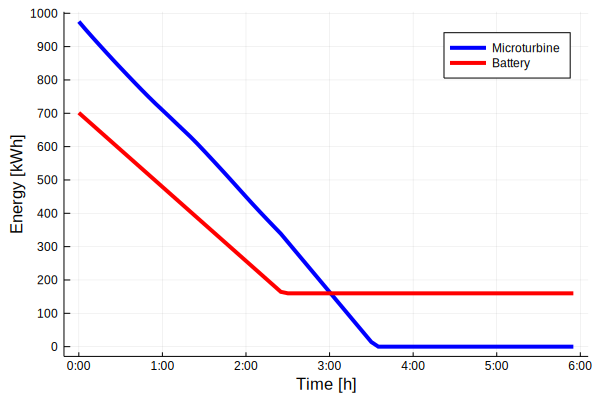

In [18]:
# Change in Energy of Battery and Microturbine

Emt_gen = zeros(1,num_time_steps)
Emt_gen[1] = Emt - Pmt_genn[1]*Δt
for v in 2:num_time_steps
    Emt_gen[v] = Emt_gen[v-1] - Pmt_genn[v]*Δt
end

tz = 1:num_time_steps

plot(tz, Emt_gen', label="Microturbine", lw = 4, c=:blue)
plot!(tz, Ces*SOCbatt', label="Battery", lw = 4, 
    xticks = (1:12:84, "$tt:00" for tt in 0:6), yticks = 0:100:1000, c=:red, legend=:best)
xlabel!("Time [h]")
ylabel!("Energy [kWh]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/MT&ES Energy.pdf")


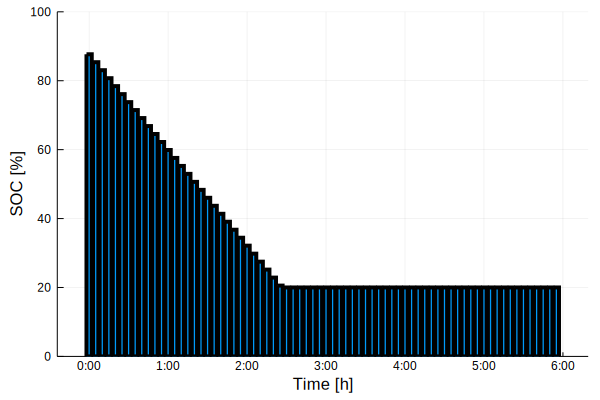

In [19]:
# Plot the battery state of charge (SOC) - %
plot(t, 100*SOCbatt', linetype=:bar, lw = 4, label=false, xticks = (1:12:84, "$tt:00" for tt in 0:6),ylims=(0,100))
xlabel!("Time [h]")
ylabel!("SOC [%]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/SOC.pdf")


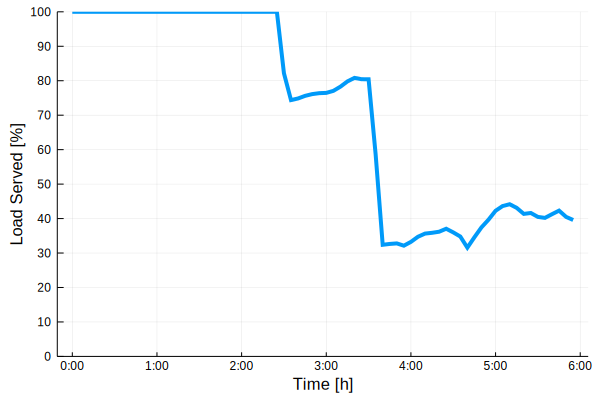

In [20]:
# Plot the percentage of the restored load per time step
    # %Restored Load = Restored Load/Actual Load Demand

P_restored_t_perc = (P_restored_t ./ Actual_Load_Real_t) .*100;
plot(t, P_restored_t_perc', lw = 4, label=false, xticks = (1:12:84, "$tt:00" for tt in 0:6), ylims=(0,100), yticks = 0:10:100)
xlabel!("Time [h]")
ylabel!("Load Served [%]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/Restored Load Per Time.pdf")


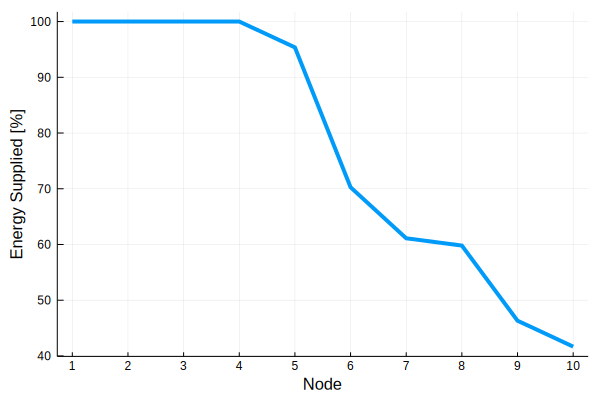

In [21]:
# Plot the percentage of the restored energy per node

E_restored_n_perc = (E_restored_n ./ Energy_n) .*100;
n = 1:num_nodes
plot(n, E_restored_n_perc', lw = 4, label=false, xticks = (1:1:10, "$tt" for tt in 1:10))
xlabel!("Node")
ylabel!("Energy Supplied [%]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/Energy Supplied Per Node.pdf")


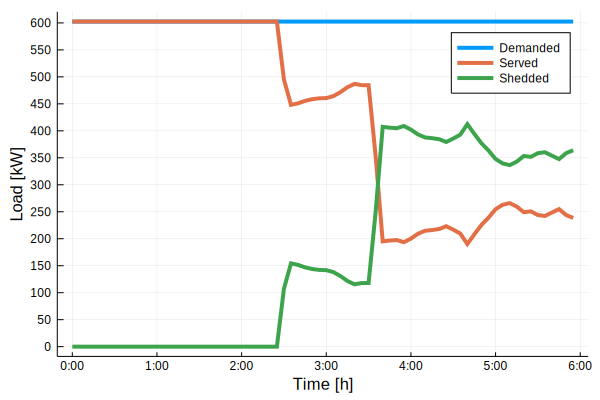

In [22]:
# Plot the actual/original load vs restored load per time step

plot(t, Actual_Load_Real_t', label="Demanded", lw = 4, grid=true, xticks = (1:12:84, "$tt:00" for tt in 0:6), yticks = 0:50:800);
plot!(t, P_restored_t', label="Served", lw = 4, grid=true)
plot!(t, (Actual_Load_Real_t' - P_restored_t'), label="Shedded", lw = 4, grid=true, legend=:best)
xlabel!("Time [h]")
ylabel!("Load [kW]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/original load vs restored load per time step.pdf")


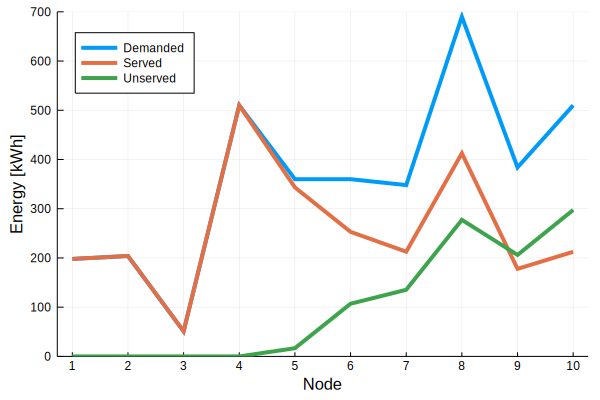

In [23]:
# Plot the actual/original load vs restored energy per node

plot(n, Energy_n', label="Demanded", lw = 4, grid=true);
plot!(n, E_restored_n', label="Served", lw = 4, grid=true)
plot!(n, (Energy_n' - E_restored_n'), label="Unserved", lw = 4,
    grid=true, xticks = (1:1:10, "$tt" for tt in 1:10), ylims=(0,700),legend=:topleft)
xlabel!("Node")
ylabel!("Energy [kWh]")

#savefig("/Users/aeseye/Desktop/Julia/Figures - Optimal - Singlestep/original load vs restored energy per time step.pdf")


In [24]:
Priorized_total_restored_load = sum(load_priority_weight[1:num_nodes] .* P_restoredd[1:num_nodes, 1:num_time_steps])

20380.142655365

In [25]:
Total_restored_load = sum(P_restoredd[1:num_nodes, 1:num_time_steps])

30899.529909300003

In [26]:
Total_restored_energy = sum(P_restoredd[1:num_nodes, 1:num_time_steps].*Δt)

2574.9608257750006

In [27]:
Penalized_total_wind_curtailment = alpha*sum(Pwt_cutt[1:num_time_steps])

0.0

In [28]:
Penalized_total_pv_curtailment = beta*sum(Ppv_cutt[1:num_time_steps])

0.0